## Preparation

In [1]:
!pip install efficientnet_pytorch
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import re
import pandas as pd
import numpy as np
from numpy import printoptions
from tqdm import tqdm
from io import StringIO
import random
import requests
import warnings
import tarfile
import time
import json
import os
from PIL import Image
from collections import Counter
import torch
from torch import nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import precision_score, recall_score, f1_score
import pickle
from shutil import copyfile

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=0e8eafc1d66e6c00f358d19dbfc119db74c34d32fa78858e04182b94fe1f3d51
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [2]:
# Fix all seeds to make experiments reproducible
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
torch.backends.cudnn.deterministic = True

# ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### load and process dataset

In [3]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
if not os.path.exists('/content/2021s1comp5329assignment2.zip'):
    link = '1243XACf-GxdGc4GV__MY-BWWV3a7xK5I'  # Restricted shared link
    downloaded = drive.CreateFile({'id':link}) 
    downloaded.GetContentFile('2021s1comp5329assignment2.zip')
    !unzip 2021s1comp5329assignment2.zip

Streaming output truncated to the last 5000 lines.
  inflating: COMP5329S1A2Dataset/data/550.jpg  
  inflating: COMP5329S1A2Dataset/data/5500.jpg  
  inflating: COMP5329S1A2Dataset/data/5501.jpg  
  inflating: COMP5329S1A2Dataset/data/5502.jpg  
  inflating: COMP5329S1A2Dataset/data/5503.jpg  
  inflating: COMP5329S1A2Dataset/data/5504.jpg  
  inflating: COMP5329S1A2Dataset/data/5505.jpg  
  inflating: COMP5329S1A2Dataset/data/5506.jpg  
  inflating: COMP5329S1A2Dataset/data/5507.jpg  
  inflating: COMP5329S1A2Dataset/data/5508.jpg  
  inflating: COMP5329S1A2Dataset/data/5509.jpg  
  inflating: COMP5329S1A2Dataset/data/551.jpg  
  inflating: COMP5329S1A2Dataset/data/5510.jpg  
  inflating: COMP5329S1A2Dataset/data/5511.jpg  
  inflating: COMP5329S1A2Dataset/data/5512.jpg  
  inflating: COMP5329S1A2Dataset/data/5513.jpg  
  inflating: COMP5329S1A2Dataset/data/5514.jpg  
  inflating: COMP5329S1A2Dataset/data/5515.jpg  
  inflating: COMP5329S1A2Dataset/data/5516.jpg  
  inflating: COMP532

In [4]:
FILENAME_TRAIN = '/content/COMP5329S1A2Dataset/train.csv'
FILENAME_TEST = '/content/COMP5329S1A2Dataset/test.csv'

## Process Text

In [5]:
# deal with lines cannot be read
with open(FILENAME_TRAIN) as fp:
    # read a list of lines into data
    data = fp.readlines()

data[4790] = data[4790].replace("/", "")
data[14716] = data[14716].replace("/", "")
data[14961] = data[14961].replace("/", "")
data[29895] = data[29895].replace("/", "")

# and write everything back
with open(FILENAME_TRAIN, 'w') as file:
    file.writelines(data)

In [6]:
# load data to dataframe
with open(FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train_origin = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [7]:
# remove all "
df_train_origin = df_train_origin.drop(columns = 'Caption').join(df_train_origin['Caption'].str.replace('\"', ''))
df_test = df_test.drop(columns = 'Caption').join(df_test['Caption'].str.replace('\"', ''))

### Get Word Embedding Table

#### Load Pre-trained Word Embedding Model

In [8]:
# Get Corpus
whole_sentences = pd.concat([df_train_origin['Caption'], df_test['Caption']], axis=0, ignore_index=True)

import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords as sw
STOPWORDS = set(sw.words('english'))

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#### Define `prepare_text` Function

In [9]:
def prepare_text(sentences): # string to pure word
    prepared_sents = []
    for text in sentences:
        text = text.lower() # lowercase
        text = re.sub(r'[^A-Za-z]+', ' ', text) # remove symbols / digits
        # text = re.sub(r'[0-9]','',text)
        pure_text = []
        for item in text.split():
            if item not in STOPWORDS: # remove stopword
                pure_text.append(item)

        text_le = [lemmatizer.lemmatize(word) for word in pure_text] # lemmatizer
        prepared_sents.append(text_le)
    return prepared_sents

#### Get Max Len

In [10]:
max_seq_len = max(len(s) for s in prepare_text(whole_sentences))
max_seq_len

28

#### Load Pretrained Embedding Table & Make `word_index` and `word_list`

In [11]:
if not os.path.exists('/content/emb_table.pkl'):
    link = '1JC45luon-QgqDm8oo8f_KMm_6DGueO1X'  # Restricted shared link
    downloaded = drive.CreateFile({'id':link}) 
    downloaded.GetContentFile('emb_table.pkl')

def load_obj(name ):
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)
emb_table = load_obj("/content/emb_table")
emb_table.shape

processed_whole_sents = prepare_text(whole_sentences)
processed_whole_sents[1]

vocab_list = []
for sent in processed_whole_sents:
    for word in sent:
        vocab_list.append(word)
        
# Create the Embedding lookup table
word_set = set()
min_freq = 5
c = Counter(vocab_list)
for i in c:
    if c[i] >= min_freq:
        word_set.add(i)
word_set.add('[PAD]')
word_set.add('[UNKOWN]')
word_list=list(word_set)
word_list.sort()
word_index = {}
for i, word in enumerate(word_list):
    word_index[word] = i
    
emb_table.shape

(2218, 300)

### split into train set and validation set

In [12]:
df_train = df_train_origin
df_val = df_train[24000:] # 6000 samples for evaluation
df_train = df_train[:24000] # 24000 samples for train

In [13]:
# save splitted train file
df_train.to_csv("/content/COMP5329S1A2Dataset/train_split.csv", index=False)
df_train

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.
...,...,...,...
23995,23995.jpg,1,A group of people floating on top of waves in ...
23996,23996.jpg,1,A man wearing an orange tie and a woman wearin...
23997,23997.jpg,1 10 3 6,A large sign is lit up on a dark city street.
23998,23998.jpg,1 15,children learning to play tennis on a clay court


In [14]:
# save splitted val file
df_val.to_csv("/content/COMP5329S1A2Dataset/val_split.csv", index=False)
df_val

,ImageID,Labels,Caption
24000,24000.jpg,1,A young girl walking on a road carrying an umb...
24001,24001.jpg,1,A woman with a large black purse holding an um...
24002,24002.jpg,1,Two kids play over a soccer ball during a game.
24003,24003.jpg,1,A man standing and cutting food at a counter.
24004,24004.jpg,5,A plane is at the airport preparing to take off.
...,...,...,...
29995,29995.jpg,8 1 2,A picture of a truck that is in the middle of ...
29996,29996.jpg,1,A plate topped with a pizza being cut with a s...
29997,29997.jpg,1,A man riding a snowboard on top of snow.
29998,29998.jpg,1,This photo shows people skiing in the mountains.


### get label information

In [15]:
# Label distribution

label_list = []

for i in df_train_origin['Labels']:
    label_list.extend(i.split())
label_list = sorted([int(i) for i in label_list])
label_list = [str(i) for i in label_list]

# plt.style.use('ggplot')
# plt.title("Label distribution")
# plt.hist(label_list, bins=18)
# plt.show()

In [16]:
# create a label set
label_set = set(label_list)
label_set = sorted([int(i) for i in label_set])
label_set

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]

In [17]:
# number of class
N_CLASS = len(label_set)
N_CLASS

18

In [18]:
# count label frequency
count_dic = {}
for i in label_set:
    count_dic[str(i)] = 0
for i in label_list:
    if i in count_dic:
        count_dic[i] += 1
print(count_dic)

{'1': 22797, '2': 1164, '3': 4365, '4': 1272, '5': 1132, '6': 1395, '7': 1221, '8': 2210, '9': 1042, '10': 1471, '11': 604, '13': 605, '14': 252, '15': 1934, '16': 1099, '17': 1430, '18': 1525, '19': 1020}


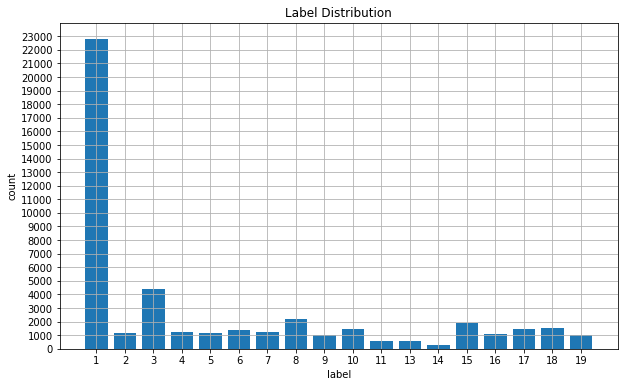

In [46]:
# get the label distribution plot

plt.figure(figsize=(10,6))
plt.bar(range(len(count_dic)), list(count_dic.values()), align='center')
plt.xticks(range(len(count_dic)), list(count_dic.keys()))
plt.xlabel('label')
plt.ylabel('count')
plt.ylim((0, 24000))
plt.yticks(np.arange(0, 24000, step=1000))
plt.grid()
plt.title("Label Distribution")
plt.show()

## OOP Classes and Functions

#### Tokenizer

In [20]:
class A2Tokenizer:
    def __init__(self):
        pass
    def tokenize(self, sentences, seq_len, word_index):
        sentences = prepare_text(sentences)
        sent_encoded = []
        for sent in sentences:
            temp_encoded = [word_index[word] if word in word_index else word_index['[UNKOWN]'] for word in sent]
            if len(temp_encoded) < seq_len:
                temp_encoded += [word_index['[PAD]']] * (seq_len - len(temp_encoded))
            else:
                temp_encoded = temp_encoded[:seq_len]
            sent_encoded.append(temp_encoded)
        return sent_encoded

### A2BiLSTM

In [21]:
vocab_size = emb_table.shape[0]
emb_dim = emb_table.shape[1]

In [22]:
class A2BiLSTM(nn.Module):
    def __init__(self, n_classes, vocab_size, pretrain = False, requires_grad = True, n_hidden = 300, emb_dim = 300):
        super(A2BiLSTM, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        # Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_classes)
        self.sigm = nn.Sigmoid()

        #set pre-train model
        if pretrain:
            !pip install -U -q PyDrive
            from pydrive.auth import GoogleAuth
            from pydrive.drive import GoogleDrive
            from google.colab import auth
            from oauth2client.client import GoogleCredentials
            # Authenticate and create the PyDrive client.
            auth.authenticate_user()
            gauth = GoogleAuth()
            gauth.credentials = GoogleCredentials.get_application_default()
            drive = GoogleDrive(gauth)

            link = '18q4Atv3gZOUj_DX6IbcflsbTkX2WuVTF'
            downloaded = drive.CreateFile({'id':link}) 
            downloaded.GetContentFile('852WE10.pth')

            weights = torch.load('/content/852WE10.pth')
            self.load_state_dict(weights)

        #set fine-tune
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad=False

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len
        lstm_out, (h_n,c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return self.sigm(z)
        
    def extract_features(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n,c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        # z = self.linear(hidden_out)
        return self.sigm(hidden_out)

### A2EfficientNet

In [23]:
class A2EfficientNet(nn.Module):
    def __init__(self, n_classes=18, pretrain=False, requires_grad=True):
        super().__init__()
        EN = EfficientNet.from_pretrained('efficientnet-b4')
        EN._fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features = EN._fc.in_features, out_features = n_classes)
        )
        self.base_model = EN
        self.sigm = nn.Sigmoid()

        #set pre-train model
        if pretrain:
            !pip install -U -q PyDrive
            from pydrive.auth import GoogleAuth
            from pydrive.drive import GoogleDrive
            from google.colab import auth
            from oauth2client.client import GoogleCredentials
            # Authenticate and create the PyDrive client.
            auth.authenticate_user()
            gauth = GoogleAuth()
            gauth.credentials = GoogleCredentials.get_application_default()
            drive = GoogleDrive(gauth)

            link = '1cgZxk3MEsjwQMuxBcM_KrbD9lebEgwWH'
            downloaded = drive.CreateFile({'id':link}) 
            downloaded.GetContentFile('870EffNetB4.pth')

            weights = torch.load('/content/870EffNetB4.pth')
            self.load_state_dict(weights)

        #set fine-tune
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad=False

    def forward(self, x):
        return self.sigm(self.base_model(x))

    def extract_features(self, x):
        return self.sigm(self.base_model.extract_features(x))

### A2Dataset

In [24]:
# Simple dataloader and label binarization, that is converting test labels into binary arrays of length 18 (number of classes) with 1 in places of applicable labels).
class A2Dataset(Dataset):
    def __init__(self, data_path, type, transforms=None):
        # data_path: the root path of dataset
        # type: dataset type, one of ['train', 'test', 'val', 'whole'], where 'whole' means the whole training set without splitting
        # transforms: img tranfroms
        self.transforms = transforms
        # self.tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
        self.type = type
        self.data_path = data_path
        if self.type == 'train':
            file_path = os.path.join(data_path, 'train_split.csv')
        elif self.type == 'test':
            file_path = os.path.join(data_path, 'test.csv')
        elif self.type == 'val':
            file_path = os.path.join(data_path, 'val_split.csv')
        elif self.type == 'whole':
            file_path = os.path.join(data_path, 'train.csv')
        with open(file_path) as file:
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
            df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
        self.samples = df
        
        if self.type != "test":
            label_set = []
            for i in self.samples["Labels"]:
                label_set.extend(i.split())
            label_set = set(label_set)
            label_set = sorted([int(i) for i in label_set])

            self.imgs = []
            self.labels = []
            for index, row in self.samples.iterrows():
                self.imgs.append(row['ImageID'])
                self.labels.append(row['Labels'])

            self.classes = label_set
            self.labels = self.samples['Labels']
            self.caption = self.samples['Caption']
            self.img_id = self.samples['ImageID']


            for item_id in range(len(self.labels)):
                item = self.labels[item_id].split()
                vector = [1 if str(cls) in item else 0 for cls in self.classes ]
                self.labels[item_id] = np.array(vector, dtype=float)

        else:
            self.imgs = []
            for index, row in self.samples.iterrows():
                self.imgs.append(row['ImageID'])

            self.caption = self.samples['Caption']
            self.img_id = self.samples['ImageID']
            self.caption = self.samples['Caption']

        print("Loading {} set with {} samples".format(self.type, len(self.imgs)))

    def __getitem__(self, item):
        # process caption
        caption = self.caption[item]
        
        # caption = self.tokenizer.encode_plus(
        #     caption,
        #     None,
        #     add_special_tokens=True,
        #     max_length=28,
        #     pad_to_max_length=True,
        #     return_token_type_ids=True,
        #     truncation=True
        # )
        # ids = caption['input_ids']
        # mask = caption['attention_mask']
        # token_type_ids = caption["token_type_ids"]


        # process img and target
        if self.type != "test":
            target =  torch.tensor(self.labels[item], dtype=torch.float)
            img_path = os.path.join(self.data_path, 'data', self.samples['ImageID'][item])
            img = Image.open(img_path)
            if self.transforms is not None:
                img = self.transforms(img)
            
            out_data =  {
                # 'ids': torch.tensor(ids, dtype=torch.long),
                # 'mask': torch.tensor(mask, dtype=torch.long),
                # 'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'caption': caption,
                'img': img,
                'target': target
            }
            return out_data
        else:
            img_path = os.path.join(self.data_path, 'data', self.samples['ImageID'][item])
            img = Image.open(img_path)
            if self.transforms is not None:
                img = self.transforms(img)
            
            out_data =  {
                # 'ids': torch.tensor(ids, dtype=torch.long),
                # 'mask': torch.tensor(mask, dtype=torch.long),
                # 'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'caption': caption,
                'img': img
            }
            return out_data

    def __len__(self):
        return len(self.imgs)

Loading train set with 24000 samples


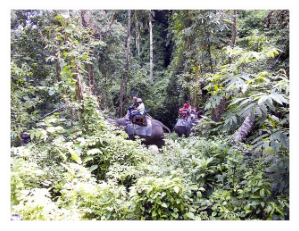

In [25]:
# Let's take a look at the data we have. To do it we need to load the dataset without augmentations.
dataset_train = A2Dataset("/content/COMP5329S1A2Dataset", "train")

# A simple function for visualization.
def show_sample(img, binary_img_labels):
    # Convert the binary labels back to the text representation.    
    try:
        plt.imshow(img)
    except:
        plt.imshow(img.reshape(256,256,-1))
    plt.axis('off')
    plt.show()

show_sample(dataset_train[2]['img'],dataset_train[2]['target'])

### Metrics Function

In [26]:
# Use threshold to define predicted labels and invoke sklearn's metrics with different averaging strategies.
def calculate_metrics(preds, target, threshold=0.5):
    predicted_labels = []
    for raw_pred in preds:
        if sum(raw_pred>threshold) == 0:
            temp = np.zeros((18))
            temp[np.argmax(raw_pred[1])] = 1
            predicted_labels.append(temp)
        else:
            predicted_labels.append(np.array(raw_pred > threshold, dtype=float))

    preds = np.array(predicted_labels, dtype=float)
    for pred in preds:
        if sum(pred != 0) == 0:
            print('wrong')
    return  {
            'f1_score': f1_score(y_true=target, y_pred=preds, average='samples'),
            }

### Checkpoint

In [27]:
# Here is an auxiliary function for checkpoint saving.
def checkpoint_save(model, save_path, epoch):
    f = os.path.join(save_path, 'checkpoint-{:06d}.pth'.format(epoch))
    if 'module' in dir(model):
        torch.save(model.module.state_dict(), f)
    else:
        torch.save(model.state_dict(), f)
    print('saved checkpoint:', f)

## Train

### Define transform

In [28]:
# define a transform
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Test preprocessing
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
print(tuple(np.array(np.array(mean)*255).tolist()))

# Train preprocessing
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5),
                            shear=None, resample=False, 
                            fillcolor=tuple(np.array(np.array(mean)*255).astype(int).tolist())),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

(123.675, 116.28, 103.53)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1315: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1329: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


### Define hyper parameters

In [29]:
# Initialize the training parameters.
num_workers = 4 # Number of CPU processes for data preprocessing
lr = 1e-4 # Learning rate
batch_size = 16
save_freq = 1 # Save checkpoint frequency (epochs)
test_freq = 100 # Test model frequency (iterations)
max_epoch_number = 2 # Number of epochs for training 
# Note: on the small subset of data overfitting happens after 30-35 epochs

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

vocab_size = len(word_list)
emb_dim = 300
n_hidden = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Save path for checkpoints
save_path = 'chekpoints/'

# word embedding
seq_len = max_seq_len

### Define `dataset`

In [30]:
# Initialize the dataloaders for training.
val_dataset = A2Dataset("/content/COMP5329S1A2Dataset", "val", val_transform)
train_dataset = A2Dataset("/content/COMP5329S1A2Dataset", "train", train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

Loading val set with 6000 samples
Loading train set with 24000 samples


### Define `model` and `tokenizer`

In [31]:
n_classes = len(train_dataset.classes)
cv_model = A2EfficientNet(n_classes=n_classes, pretrain=True, requires_grad=False)
nlp_model = A2BiLSTM(n_classes=n_classes, pretrain=True, requires_grad=False, vocab_size = vocab_size, n_hidden = n_hidden, emb_dim = emb_dim)

link = '1Elj1mhcWVWx_pzW3IRDZoVUdbo0wT8_T'
downloaded = drive.CreateFile({'id':link}) 
downloaded.GetContentFile('894Classifier_2392_24000.pth')
# Define Classifier
classifier = nn.Sequential(
    nn.Linear(in_features=36, out_features=2392),
    nn.ReLU(),
    nn.Linear(in_features=2392, out_features=n_classes),
    nn.Sigmoid()
)
classifier_weights = torch.load('/content/894Classifier_2392_24000.pth')
classifier.load_state_dict(classifier_weights)

# Switch model to GPU.
cv_model = cv_model.to(device)
nlp_model = nlp_model.to(device)
classifier = classifier.to(device)

tokenizer = A2Tokenizer()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


### Define `optimizer`

In [32]:
optimizer = torch.optim.AdamW(classifier.parameters(), lr)

### Define `criterion`

In [33]:
criterion = nn.BCELoss().to(device)

### Train and Validation

In [34]:
os.makedirs(save_path, exist_ok=True)
# Run training
epoch = 0
iteration = 0
while True:
    batch_losses = []
    for data in train_dataloader:
        cv_model.train()
        nlp_model.train()
        # prepare image features
        targets = data['target'].to(device)
        imgs = data['img'].to(device)

        # prepare text input
        captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
        captions = torch.from_numpy(np.array(captions)).to(device)

        # get features
        # img_features = cv_model.feature_extract(imgs)
        img_features = cv_model(imgs)
        nlp_features = nlp_model(captions)

        # calculate loss
        features_concat = torch.cat((img_features, nlp_features),1)
        combined_model_result = classifier(features_concat)

        # cv_loss = criterion(nn.Sigmoid(img_features), targets.type(torch.float))
        loss = criterion(combined_model_result, targets.type(torch.float))
        batch_loss_value = loss.item()

        # backward
        loss.backward()

        # update grad
        optimizer.step()
        optimizer.zero_grad()

        batch_losses.append(batch_loss_value)
        with torch.no_grad():
            result = calculate_metrics(combined_model_result.cpu().numpy(), targets.cpu().numpy())
        if iteration % test_freq == 0:
            with torch.no_grad():
                model_result = []
                targets = []
                for data in val_dataloader:
                    cv_model.eval()
                    nlp_model.eval()
                    # prepare image features
                    batch_targets = data['target'].to(device)
                    imgs = data['img'].to(device)

                    # prepare text input
                    captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
                    captions = torch.from_numpy(np.array(captions)).to(device)

                    # get features
                    img_features = cv_model(imgs)
                    nlp_features = nlp_model(captions)

                    # calculate loss
                    features_concat = torch.cat((img_features, nlp_features),1)
                    model_batch_result = classifier(features_concat)
                    model_result.extend(model_batch_result.cpu().numpy())

                    targets.extend(batch_targets.cpu().numpy())
            result = calculate_metrics(np.array(model_result), np.array(targets))
            print("epoch:{:2d} iter:{:3d}   Validation: F1 score: {:.3f}".format(epoch, iteration, result['f1_score']))
        iteration += 1

    loss_value = np.mean(batch_losses)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iteration, loss_value))
    if epoch % save_freq == 0:
        checkpoint_save(classifier, save_path, epoch)
    epoch += 1
    if max_epoch_number <= epoch:
        break

epoch: 0 iter:  0   Validation: F1 score: 0.894
epoch: 0 iter:100   Validation: F1 score: 0.894
epoch: 0 iter:200   Validation: F1 score: 0.894
epoch: 0 iter:300   Validation: F1 score: 0.895
epoch: 0 iter:400   Validation: F1 score: 0.894
epoch: 0 iter:500   Validation: F1 score: 0.894
epoch: 0 iter:600   Validation: F1 score: 0.895
epoch: 0 iter:700   Validation: F1 score: 0.895
epoch: 0 iter:800   Validation: F1 score: 0.895
epoch: 0 iter:900   Validation: F1 score: 0.895
epoch: 0 iter:1000   Validation: F1 score: 0.895
epoch: 0 iter:1100   Validation: F1 score: 0.894
epoch: 0 iter:1200   Validation: F1 score: 0.895
epoch: 0 iter:1300   Validation: F1 score: 0.895
epoch: 0 iter:1400   Validation: F1 score: 0.894
epoch: 0 iter:1500 train: loss:0.057
saved checkpoint: chekpoints/checkpoint-000000.pth
epoch: 1 iter:1500   Validation: F1 score: 0.896
epoch: 1 iter:1600   Validation: F1 score: 0.895
epoch: 1 iter:1700   Validation: F1 score: 0.895
epoch: 1 iter:1800   Validation: F1 scor

## Inference

### Train with whole dataset

In [35]:
whole_dataset = A2Dataset("/content/COMP5329S1A2Dataset", "whole", train_transform)
whole_dataloader = DataLoader(whole_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

Loading whole set with 30000 samples


In [36]:
os.makedirs(save_path, exist_ok=True)
# Run training
epoch = 0
iteration = 0
while True:
    batch_losses = []
    for data in whole_dataloader:
        cv_model.train()
        nlp_model.train()
        # prepare image features
        targets = data['target'].to(device)
        imgs = data['img'].to(device)

        # prepare text input
        captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
        captions = torch.from_numpy(np.array(captions)).to(device)

        # get features
        # img_features = cv_model.feature_extract(imgs)
        img_features = cv_model(imgs)
        nlp_features = nlp_model(captions)

        # calculate loss
        features_concat = torch.cat((img_features, nlp_features),1)
        combined_model_result = classifier(features_concat)

        # cv_loss = criterion(nn.Sigmoid(img_features), targets.type(torch.float))
        loss = criterion(combined_model_result, targets.type(torch.float))
        batch_loss_value = loss.item()

        # backward
        loss.backward()

        # update grad
        optimizer.step()
        optimizer.zero_grad()

        batch_losses.append(batch_loss_value)
        with torch.no_grad():
            result = calculate_metrics(combined_model_result.cpu().numpy(), targets.cpu().numpy())
        if iteration % test_freq == 0:
            with torch.no_grad():
                model_result = []
                targets = []
                for data in val_dataloader:
                    cv_model.eval()
                    nlp_model.eval()
                    # prepare image features
                    batch_targets = data['target'].to(device)
                    imgs = data['img'].to(device)

                    # prepare text input
                    captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
                    captions = torch.from_numpy(np.array(captions)).to(device)

                    # get features
                    img_features = cv_model(imgs)
                    nlp_features = nlp_model(captions)

                    # calculate loss
                    features_concat = torch.cat((img_features, nlp_features),1)
                    
                    model_batch_result = classifier(features_concat)
                    model_result.extend(model_batch_result.cpu().numpy())

                    targets.extend(batch_targets.cpu().numpy())
            result = calculate_metrics(np.array(model_result), np.array(targets))
            print("epoch:{:2d} iter:{:3d}   Validation: F1 score: {:.3f}".format(epoch, iteration, result['f1_score']))
        iteration += 1

    loss_value = np.mean(batch_losses)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iteration, loss_value))
    if epoch % save_freq == 0:
        checkpoint_save(classifier, save_path, epoch)
    epoch += 1
    if max_epoch_number <= epoch:
        break

epoch: 0 iter:  0   Validation: F1 score: 0.895
epoch: 0 iter:100   Validation: F1 score: 0.896
epoch: 0 iter:200   Validation: F1 score: 0.896
epoch: 0 iter:300   Validation: F1 score: 0.895
epoch: 0 iter:400   Validation: F1 score: 0.896
epoch: 0 iter:500   Validation: F1 score: 0.895
epoch: 0 iter:600   Validation: F1 score: 0.896
epoch: 0 iter:700   Validation: F1 score: 0.896
epoch: 0 iter:800   Validation: F1 score: 0.896
epoch: 0 iter:900   Validation: F1 score: 0.896
epoch: 0 iter:1000   Validation: F1 score: 0.895
epoch: 0 iter:1100   Validation: F1 score: 0.896
epoch: 0 iter:1200   Validation: F1 score: 0.897
epoch: 0 iter:1300   Validation: F1 score: 0.895
epoch: 0 iter:1400   Validation: F1 score: 0.896
epoch: 0 iter:1500   Validation: F1 score: 0.896
epoch: 0 iter:1600   Validation: F1 score: 0.896
epoch: 0 iter:1700   Validation: F1 score: 0.896
epoch: 0 iter:1800   Validation: F1 score: 0.896
epoch: 0 iter:1875 train: loss:0.061
saved checkpoint: chekpoints/checkpoint-00

## Submission


In [37]:
# Test preprocessing
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [38]:
# Run inference on the val data
test_dataset = A2Dataset("/content/COMP5329S1A2Dataset", "test", test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

Loading test set with 10000 samples


In [39]:
with torch.no_grad():
    model_result = []
    # raw_labels = []
    for data in test_dataloader:
        cv_model.eval()
        nlp_model.eval()
        # prepare image features
        imgs = data['img'].to(device)
        captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
        captions = torch.from_numpy(np.array(captions)).to(device)

        # get features
        # img_features = cv_model.feature_extract(imgs)
        img_logits = cv_model(imgs)
        nlp_logits = nlp_model(captions)

        # calculate loss
        logits_concat = torch.cat((img_logits, nlp_logits),1)
        model_batch_result = classifier(logits_concat)
        model_result.extend(model_batch_result.cpu().numpy())


predicted_labels = []
for raw_pred in model_result:
    if len(np.argwhere(raw_pred > 0.5)[:, 0]) > 0:
        predicted_labels.append(np.array(label_set)[np.argwhere(raw_pred > 0.5)[:, 0]])
    else:
        predicted_labels.append(np.array([np.array(label_set)[np.argmax(raw_pred)]]))
len(predicted_labels)

10000

In [40]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
save_obj(model_result, "model_result")

In [41]:
# make a csv file
df = pd.DataFrame(columns=["ImageID", "Labels"])
# Creating the Second Dataframe using dictionary
for index, value in enumerate(predicted_labels):
    df_temp = pd.DataFrame({"ImageID":"{}.jpg".format(30000+index), "Labels":" ".join([str(i) for i in value.tolist()])}, index=[0])
    # for appending df_temp at the end of df
    df = df.append(df_temp, ignore_index = True)

In [42]:
sum(df['Labels'] == "") # check NA

0

In [43]:
# if there is NA, then replace it by label 1, because label 1 has the highest distribution
for i in range(10000):
    if df.loc[i,'Labels'] == '':
        df.loc[i,'Labels'] = 1

In [45]:
from datetime import datetime
now = datetime.now()
timestamp = datetime.timestamp(now) + 3600 * 9
timestamp = datetime.fromtimestamp(timestamp)

# df.to_csv("/content/submission_{}.csv".format(str(timestamp)), index= False)
df.to_csv("/content/Predicted_labels.csv".format(str(timestamp)), index= False)